<a href="https://colab.research.google.com/github/rua-maomao/ECG-EMG-noise-reduce/blob/main/EMG_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install PyWavelets
!pip install PyWavelets

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt  # Import PyWavelets library
from scipy.fft import fft, fftfreq
from scipy.signal import butter, sosfilt, stft, cwt, morlet
from scipy.signal import firwin, filtfilt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# load data
data_path = '/content/EXG_Channel_1_TF-CE PBS.xlsx'
data = pd.read_excel(data_path)

time = data['Time(s)'].to_numpy()
potential = data['Potential(μV)'].to_numpy()

dt = time[1] - time[0]

NameError: name 'pd' is not defined

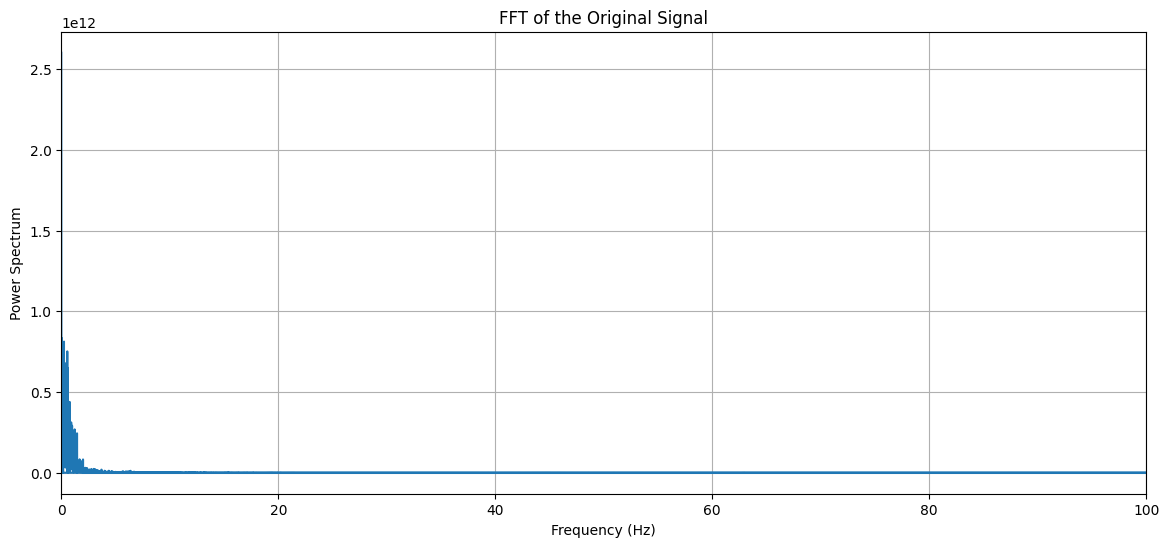

In [ ]:
fs = 200  # Replace with your actual sampling frequency in Hz

# FFT
fft_result = fft(potential)
frequencies = fftfreq(potential.size, dt)
power_spectrum = np.abs(fft_result) ** 2

# plot
plt.figure(figsize=(14, 6))
plt.plot(frequencies, power_spectrum)
plt.title('FFT of the Original Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum')
plt.xlim([0, fs / 2])
plt.grid(True)
plt.show()

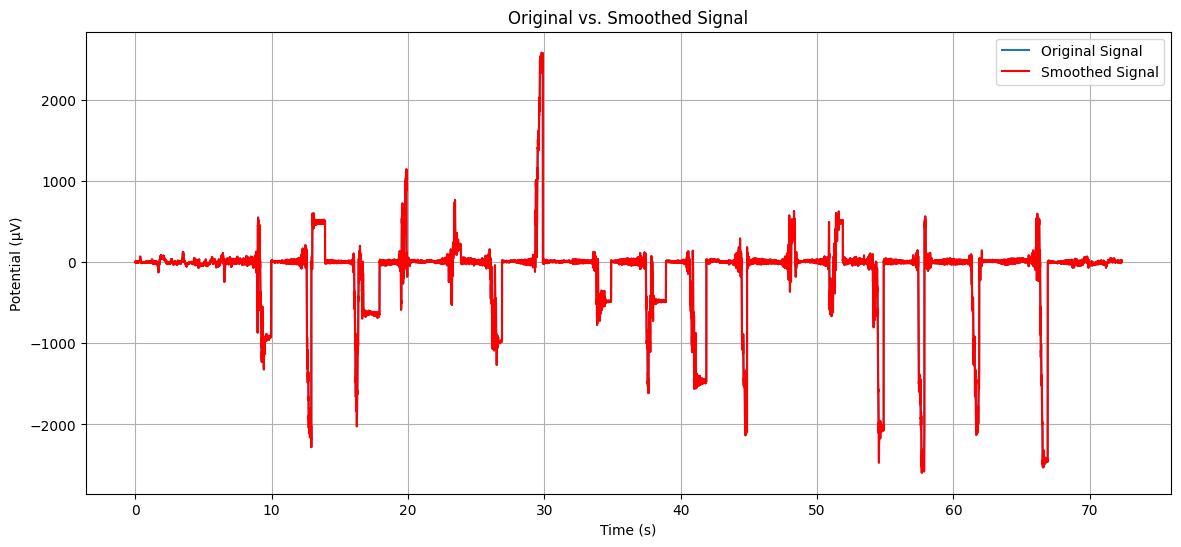

In [ ]:
# avreage moving
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# apply avreage moving
window_size = 1
smoothed_potential = moving_average(potential, window_size)
adjusted_time = time[window_size-1:]

# plot
plt.figure(figsize=(14, 6))
plt.plot(time, potential, label='Original Signal')
plt.plot(adjusted_time, smoothed_potential, label='Smoothed Signal', color='red')
plt.title('Original vs. Smoothed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Potential (μV)')
plt.legend()
plt.grid(True)
plt.show()

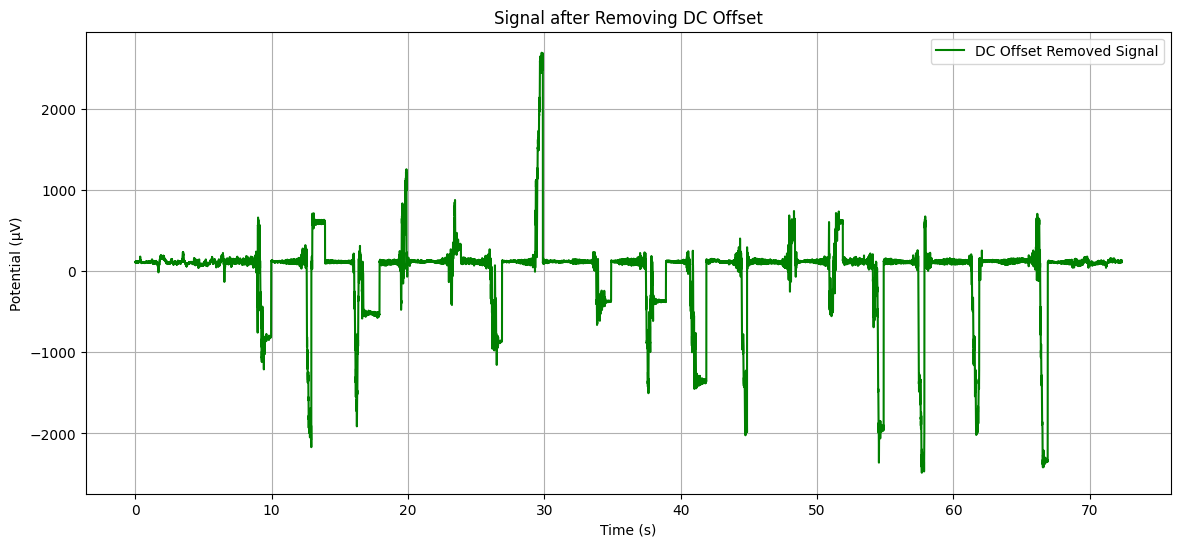

In [ ]:
# DC offset
dc_offset_removed_potential = smoothed_potential - np.mean(smoothed_potential)

# plot
plt.figure(figsize=(14, 6))
plt.plot(adjusted_time, dc_offset_removed_potential, label='DC Offset Removed Signal', color='green')
plt.title('Signal after Removing DC Offset')
plt.xlabel('Time (s)')
plt.ylabel('Potential (μV)')
plt.legend()
plt.grid(True)
plt.show()


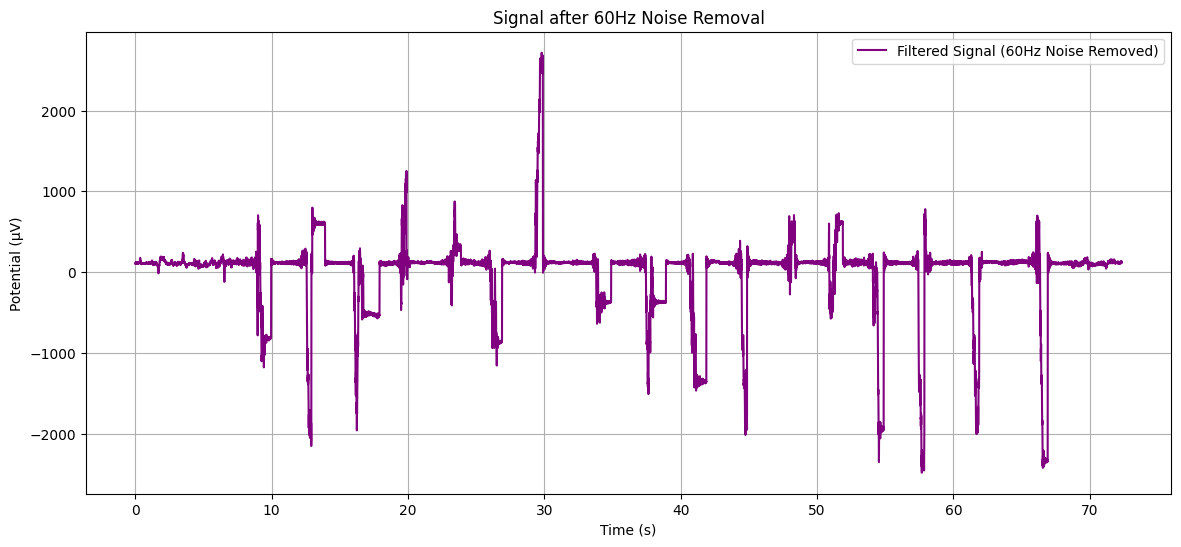

In [ ]:
# band stop
def bandstop_filter(data, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='bandstop', output='sos')
    filtered = sosfilt(sos, data)
    return filtered

# 60Hz
fs = 1/dt  # 采样频率
filtered_potential = bandstop_filter(dc_offset_removed_potential, 59, 61, fs)

# plot
plt.figure(figsize=(14, 6))
plt.plot(adjusted_time, filtered_potential, label='Filtered Signal (60Hz Noise Removed)', color='purple')
plt.title('Signal after 60Hz Noise Removal')
plt.xlabel('Time (s)')
plt.ylabel('Potential (μV)')
plt.legend()
plt.grid(True)
plt.show()

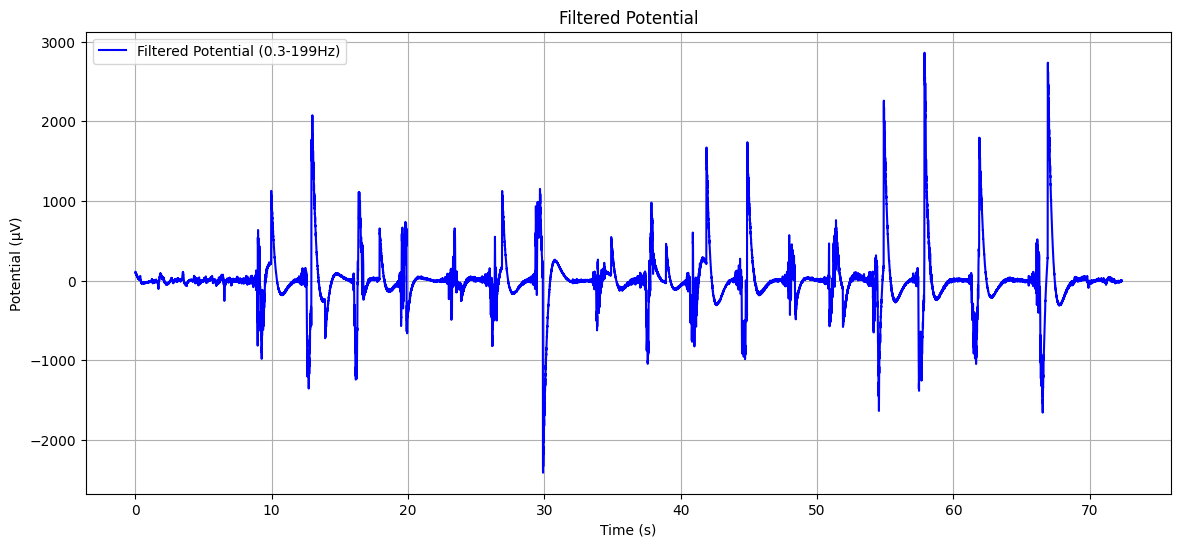

In [ ]:
# band pass
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    sos = butter(order, [lowcut, highcut], fs=fs, btype='bandpass', output='sos')
    filtered = sosfilt(sos, data)
    return filtered

# 0.3-120Hz
filtered_potential_bandpass = bandpass_filter(filtered_potential, 1/2, 199/2, fs)

# plot
plt.figure(figsize=(14, 6))
plt.plot(adjusted_time, filtered_potential_bandpass, color='blue', label='Filtered Potential (0.3-199Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Potential (μV)')
plt.title('Filtered Potential')
plt.legend()
plt.grid(True)
plt.show()


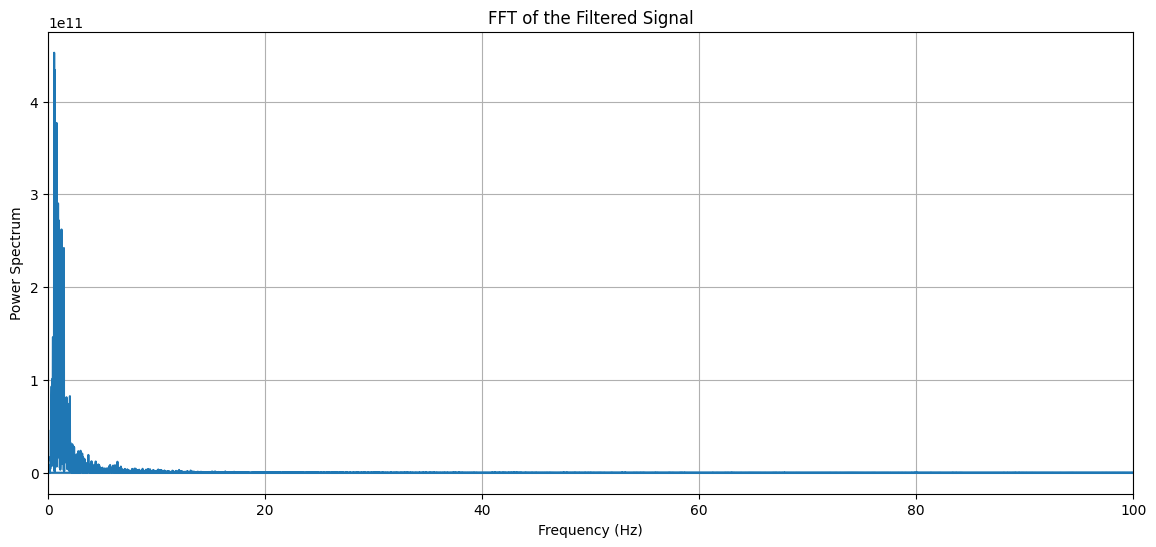

In [ ]:
# FFT
fft_result_filtered = fft(filtered_potential_bandpass)
frequencies_filtered = fftfreq(filtered_potential_bandpass.size, dt)
power_spectrum_filtered = np.abs(fft_result_filtered) ** 2

# plot
plt.figure(figsize=(14, 6))
plt.plot(frequencies_filtered, power_spectrum_filtered)
plt.title('FFT of the Filtered Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum')
plt.xlim([0, fs / 2])
plt.grid(True)
plt.show()


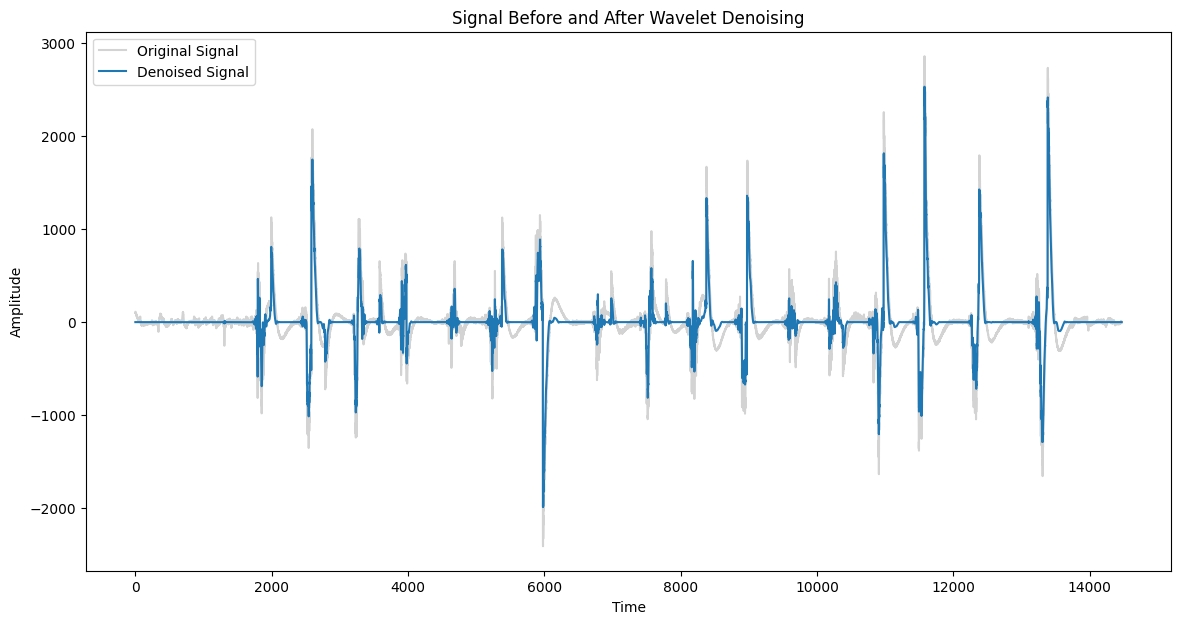

In [ ]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

data = filtered_potential_bandpass

# pywt
coeffs = pywt.wavedec(data, 'db8', level=4)

# de-noise
threshold = 0.1  # need to change
coeffs_denoised = [pywt.threshold(c, threshold*max(c)) for c in coeffs]

# re-bulid
data_denoised = pywt.waverec(coeffs_denoised, 'db8')

# plot
plt.figure(figsize=(14, 7))
plt.plot(data, label='Original Signal', color='lightgrey')
plt.plot(data_denoised, label='Denoised Signal')
plt.legend()
plt.title('Signal Before and After Wavelet Denoising')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# same length
min_length = min(len(time), len(data_denoised))
time = time[:min_length]
data_denoised = data_denoised[:min_length]

# DataFrame save
denoised_data_df = pd.DataFrame({
    'Time(s)': time,
    'Denoised Potential(μV)': data_denoised
})

# export data
export_path = '/content/filtered emg data TF-CE PBS.xlsx'

# export Excel
denoised_data_df.to_excel(export_path, index=False)
